<center><img src="img/aism_logo.png" alt="Logo AI Saturdays Madrid" title="Logo AI Saturdays Madrid" width="150"/></center>

# Week 6 Challenge - Movie Reviews Classifier

Un problema que se repite con frecuencia con los datos en forma de texto es el análisis de opiniones/sentimientos el cual, si contamos con un dataset anotado, no deja de ser un problema de clasificación supervisado.

En este _challenge_ crearemos un clasificador de texto genérico que clasifica los textos de reseñas de películas de IMDB en castellano en una de dos categorías: `negativo` o `positivo`. Para ello vamos a aplicar el teorema de Bayes haciendo uso de la implementación del algoritmo Naïve Bayes.

Para crear el dataset que vamos a usar, hemos tomado como base el que podemos encontrar en [Kaggle - IMDB Dataset of 50K Movie Reviews (Spanish)](https://www.kaggle.com/luisdiegofv97/imdb-dataset-of-50k-movie-reviews-spanish), quedándonos solo con las columnas en castellano y limpiando algunas reseñas en inglés que se habían colado.

## Importar librerías

A continuación, te dejamos indicadas las librerías que creemos que vas a necesitar importar para completar el _challenge_, pero puedes importar las que creas necesarias.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.2 MB/s eta 0:00:00


In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# import spacy
from nltk.corpus import stopwords
from unidecode import unidecode
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix

Mounted at /content/drive


## Cargar los datos

**Crear un DataFrame llamado `data` a partir del CSV que contiene los datos con las reseñas de las películas y muestra las 5 primeras filas.**

In [2]:
data = pd.read_csv('./IMDB_es.csv')
data.head()

review_es sentiment
0  Uno de los otros críticos ha mencionado que de...  positivo
1  Una pequeña pequeña producción.La técnica de f...  positivo
2  Pensé que esta era una manera maravillosa de p...  positivo
3  Básicamente, hay una familia donde un niño peq...  negativo
4  El "amor en el tiempo" de Petter Mattei es una...  positivo

## Análisis de los datos

**Muestras la información abreviada del conjunto de datos.**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_es  48182 non-null  object
 1   sentiment  48182 non-null  object
dtypes: object(2)
memory usage: 753.0+ KB


**Aparentemente no hay valores nulos, pero conviene comprobar si tenemos reseñas que son simplemente cadenas vacías ya que no nos sirven y deberíamos eliminarlas. Comprueba si hay reseñas con una longitud de menos de 10 caracteres.**

In [4]:
# Verificar si hay reseñas que son cadenas vacías
empty_reviews = data[data['review_es'].apply(lambda x: len(str(x).strip()) == 0)]
print("Reseñas vacías encontradas:")
print(empty_reviews)


Reseñas vacías encontradas:
Empty DataFrame
Columns: [review_es, sentiment]
Index: []


In [7]:

# Verificar reseñas con una longitud menor a 10 caracteres
short_reviews = data[data['review_es'].apply(lambda x: len(str(x).strip()) < 10)]
print("\nReseñas con longitud menor a 10 caracteres encontradas:")
print(short_reviews)


Reseñas con longitud menor a 10 caracteres encontradas:
      review_es sentiment
24965   Err:501  negativo
33190   Err:501  negativo


En este caso no tenemos cadenas vacías, pero como vemos aparecen reseñas que no son tales sino que parecen errores al haber sido guardadas.

**Elimina las reseñas que contienen errores. Acuérdate de resetear el índice.**

In [8]:
# Elimina los errores
data = data[data['review_es'].apply(lambda x: len(str(x).strip()) >= 10)]

In [9]:
# Resetea el índice
data.reset_index(drop=True, inplace=True)

**Muestra usando un diagrama de barras la distribución de las clases objetivo dentro de la variable `sentiment` e imprime un conteo de las mismas. ¿Qué te indica esto?**

Conteo de clases en la variable 'sentiment':
sentiment
negativo    24131
positivo    24049
Name: count, dtype: int64


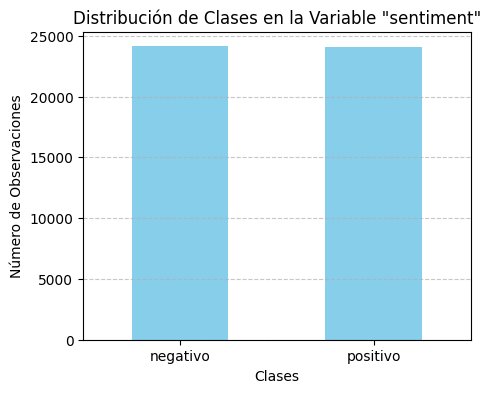

In [10]:
# Calculamos el conteo de cada clase en la columna 'sentiment'
sentiment_counts = data['sentiment'].value_counts()

# Imprime el conteo
print("Conteo de clases en la variable 'sentiment':")
print(sentiment_counts)

# Muestra el gráfico
plt.figure(figsize=(5, 4))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases en la Variable "sentiment"')
plt.xlabel('Clases')
plt.ylabel('Número de Observaciones')
plt.xticks(rotation=0)  # Rotar etiquetas en el eje x para mayor legibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
# Muestra el gráfico

# Imprime el conteo


Estamos trabajando con un conjunto de datos bastante balanceado.

## Preprocesamiento de los textos

**Crea una nueva columna llamada `review_es_clean` que contenga el texto de las reseñas en minúsculas. A partir de ahora, todas las transformaciones que vamos a realizar en los textos se harán sobre esta columna que contendrá el texto de las reseñas preprocesado.**

In [12]:
data['review_es_clean'] = data['review_es'].str.lower()

**Sustituye los signos de puntuación de los textos de las reseñas por un espacio.**

In [13]:
# Os dejamos los signos de puntuación más comunes en el idioma castellano
punctuation = r'.,;:"#$%&\'()*+/<=>@[\\]^_`{|}~¿?¡!ºª-·'

In [14]:
# Elimina los signos puntuación
data['review_es_clean'] = data['review_es_clean'].apply(lambda x: re.sub('[' + punctuation + ']', ' ', x))

# Verificar el dataframe actualizado
print("Dataframe con signos de puntuación eliminados:")
print(data.head())

Dataframe con signos de puntuación eliminados:
                                           review_es sentiment  \
0  Uno de los otros críticos ha mencionado que de...  positivo   
1  Una pequeña pequeña producción.La técnica de f...  positivo   
2  Pensé que esta era una manera maravillosa de p...  positivo   
3  Básicamente, hay una familia donde un niño peq...  negativo   
4  El "amor en el tiempo" de Petter Mattei es una...  positivo   

                                     review_es_clean  
0  uno de los otros críticos ha mencionado que de...  
1  una pequeña pequeña producción.la técnica de f...  
2  pensé que esta era una manera maravillosa de p...  
3  básicamente, hay una familia donde un niño peq...  
4  el "amor en el tiempo" de petter mattei es una...  


**Elimina los números de los textos sustituyéndolos por un espacio.**

In [15]:
data['review_es_clean'] = data['review_es_clean'].apply(lambda x: re.sub(r'\d+', ' ', x))

**Quita los espacios innecesarios tanto entre las palabras como al inicio y al final de las reseñas.**

In [16]:
# Eliminamos espacios innecesarios dentro del texto
data['review_es_clean'] = data['review_es_clean'].str.replace(r'\s{2,}', ' ',
                                                                  regex=True).str.strip()

In [17]:
# Eliminamos espacios de los extremos
data['review_es_clean'] = data['review_es_clean'].str.strip()

**(Opcional) Lemmatiza los textos usando la librería spaCy u otra de tu elección. Si haces la prueba con lemmatización y sin ella verás que los resultados a la hora de entrenar son muy similares, por lo menos usando el lemmatizador de spaCy. Al ser este un paso que tarda bastante en ejecutarse, hazlo solo si tienes tiempo.**

In [18]:
!pip install spacy

In [19]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 26.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [20]:
import spacy

# Cargar el modelo de spaCy para español
nlp = spacy.load('es_core_news_sm')

In [21]:
# Crea una función para lemmatizar los textos
def lemmatize_text(text):
    # Procesa el texto con el modelo de spaCy cargado
    doc = nlp(text)
    # Obten los lemas de cada token en el texto procesado
    lemmatized_text = ' '.join([token.lemma_ for token in doc])
    return lemmatized_text

In [22]:
# Lemmatiza los textos de las reseñas
data['review_es_clean'] = data['review_es_clean'].apply(lemmatize_text)

**Elimina las _stopwords_ de los textos de las reseñas.**

In [23]:
import nltk
# Crea una lista con las stopwords en castellano de la librería NLTK
nltk.download('stopwords')
# Definimos la lista de stopwords en español
nltk_stopwords = stopwords.words('spanish')
# Muestra la lista
print(nltk_stopwords)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [24]:
# Creamos una función para eliminar las stopwords
def remove_stopwords(text):
    # Dividirmos el texto en palabras
    words = text.split()
    # Filtramos las palabras que no son stopwords
    filtered_words = [word for word in words if word.lower() not in nltk_stopwords]
    # Unimos las palabras filtradas de nuevo en un texto
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [25]:
# Elimina las stopwords
data['review_es_clean'] = data['review_es_clean'].apply(remove_stopwords)

**Elimina los acentos de las palabras.**

In [26]:
# Crea una función para eliminar los acentos
data['review_es_clean'] = data['review_es_clean'].apply(unidecode)

In [27]:
# Elimina los acentos


**Muestras las reseñas en una lista para hacer una inspección visual de los cambios realizados hasta el momento y comprobar que todo ha ido correctamente.**

In [ ]:
process_reviews = list(data['review_es_clean'])

# Imprimimos todas las reseñas procesadas
for index, review in enumerate(process_reviews):
    print(f"Reseña {index + 1}:")
    print(review)
    print() # Imprimimos una linea en blanco para separa las reseñas

Se han truncado las últimas 5000 líneas del flujo de salida.

Reseña 608:
tiempo ser oro.esta pelicula es.debo aprender ignorar critico temblar pelicula pequeno fargo completo perdida tiempo . teatro lleno ser mismo reaccion : ? ser pelicula critico hablando?!que pieza mierda ! gancho pelicula ser hija negro movil hacia arriba buscar encontrar familia basura blanca.conseguirlo ? actuacion ser excelente . produccion ( iluminacion , conjunto , edicion , sonido ) ser aproximadamente paso encima historia minutos.lo personaje ser profundo ininteligentes.fui insultado hecho persona poder averiguar ser descaradamente obvio audiencia;la audiencia ser murmurar pantalla pelicula deber decir personaje siguiente . haber divertir hacer lavanderia .

Reseña 609:
peor.pelicula.jamas haber hecho.siempre.no tener palabra decir . , entonces realmente tener , parcela , ... nada.mierda puro ! ! ! saber como pelicula disparar estant despues ver ... .... .... ... amar pelicula misterio vampiro , alternate a

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




imagen horror fijar ultimo instancia parodia , aun asi , juego , poder asustar alguno fracasado nervioso facilmente disgustado ver bajo piel.sin embargo , rei eso.ser facil descifrar verdadero asesino actuacion ayudo.esto solo llevar potente aspecto aun mejor.anatomie ser imagen terror extranjero genero , contenido deber obtener alguno risa involuntario pico interesante cine terror aleman . /

Reseña 12723:
despues exuberante inspirador disparo aereo movimiento rapido apertura pelicula , deslizar aburrimiento absoluto nota tono final . comenzar , bueno , comenzar personaje . realmente disfrute libro , aqui ser tipo idiota dimensional haber " victima " " gilipol " escrito frente oportunidad . como alguien ver traves propietario tienda lealand gaunt ( rendimiento hammy lugar sydrow ) alla . pelicula carecer emocion , suspense , cierto , , valor entretenido . extender tiempo , pagar . ? introducir demasiado caracter molesto caracter , luego olvidar mitad mitad camino ? libro practicament

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Reseña 16892:
como pelicula tener promedio estrella alla mi.el guion ser banal , francamente insulto vida basa.lar cinematografiar venir directamente slick world of publicidad , talentoso ridley scott deber avergonzado.sin embargo , demi moore , mostrar ninguno sorpresa participar pelicula , si mirar lista canciones.en general , pelicula estilo " alto concepto " incluso don simpson avergonzacer .

Reseña 16893:
unico razon incluso dar cada ser permitir opcion dar cero cada . ser mayor perdida tiempo haber soportar . aproximadamente minuto , someter peor actuacion ( referir buen manera , nerd asesino , tener gran actuacion horrible ) parcela solo ser ridiculo , sino tener absolutamente . hacer masacre . razon incluso alquile pieza basura ser tener masacre titulo . dicho , solo haber asesinato pelicula ser bastante cojo . pasa tiempo ver nino lidiar hacer trabajo patio cualquiera cosa . hablar nino , actor nino pequeno ser probablemente actor infantil irritante bob casa cementerio . ? me

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)





Reseña 43921:
pelicula incasionante , sutil magra , " hombre traje blanco " ser aliento aire fresco formato filmic ealing studio . si bien sospechar alguno espectador moderno poder descubrir , duda lograr ser encantar forma experto , tema personaje transmitir languidamente curso pelicula . genuinamente buen guinness alec ofrecer caracterizacion fino pelicula quizas , obviamente , virtuoso " corazon coronesta amable coronet ealing , . vez , simplemente jugar personaje lugar ocho , inventor cientifico sidney stratton , siempre encontrar tono expresion correcto . junto desempeno sutil , expresivo guinness , resto elenco ser efectivo . principal jugador , cecil parker ernest thesiger destacar . thesiger absurdar obligativamente grande libre negocio paralizante influyente , mientras parker ser confiable propietario padre inefectivo , molino pivotal . padre , decir , joan greenwood , actriz comico delicios habil , pico insuperable pelicula . resplandeciente seductoro aspecto licenciatura ,

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['criticos mencionado despues ver solo oz episodio enganchado razon exactamente sucedio conmigo primera cosa golpeo oz brutalidad escenas violencia inconfiadas encuentran derecha palabra confia espectaculo debiles corazon timido espectaculo extrae punzones respecto drogas sexo violencia hardcore uso clasico palabra llama oz apodo dado penitenciario seguridad maximo oswald centra principalmente ciudad emeralda seccion experimental prision todas celulas frentes vidrio enfrentan hacia adentro privacidad alta agenda em city hogar fariarios musulmanes gangstas latinos cristianos italianos irlandeses asi esposas miradas muerte relaciones peligrosas acuerdos sombreados nunca lejos diria principal atractivo espectaculo debe hecho va espectaculos atreverian olvidate imagenes bonitas pintadas audiencias convencionales olvidan encanto olviden romance oz mete primer episodio visto sorprendio tan desagradable surrealista podia decir listo ello observe desarrolle gusto oz acostumbre altos niveles vi

## Nubes de palabras

A continuación, vamos a crear las nubes de palabras tanto de las reseñas etiquetadas como positivas como de las negativas a ver si observamos algo interesante.

**Crea dos DataFrames, uno que contenga las reseñas positivas llamado `data_pos` y otro que contenga las negativas llamado `data_neg`.**

In [ ]:
# Reseñas positivas


In [ ]:
# Reseñas negativas


**Crea una función llamada `plot_could()` que te permita visualizar las nubes de palabras con los parámetros que desees sin necesidad de escribir el mismo código una y otra vez (reutilización de código).**

**Muestra la nube de palabras de las reseñas positivas. ¿Qué palabras te llaman la atención?**

In [ ]:
# Combina las reseñas


In [ ]:
# Genera la nube de palabras


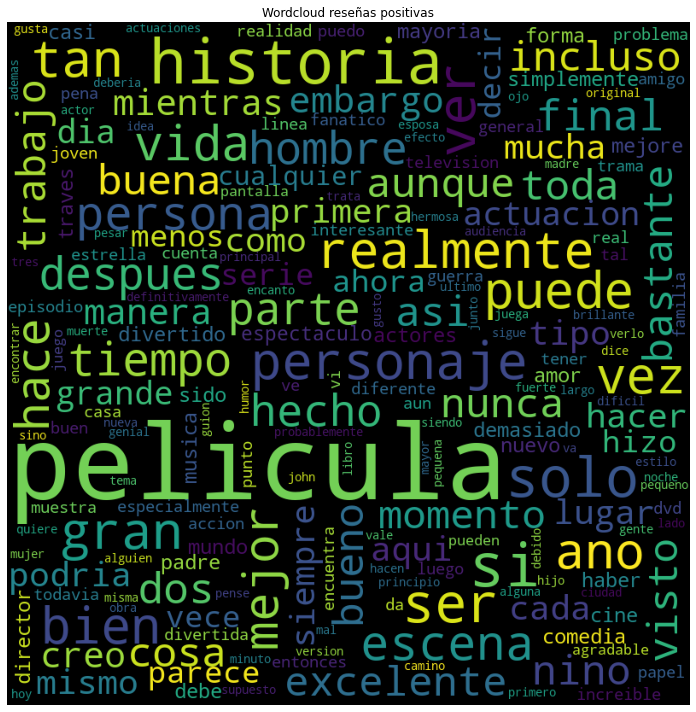

In [ ]:
# Muestra la nube de palabras


Vemos que aparecen palabras como 'excelente', 'mejor', 'buen', 'disfrutar', 'divertido', etc.

**Muestra la nube de palabras de las reseñas negativas. ¿Qué palabras te llaman la atención?**

In [ ]:
# Combina las reseñas


In [ ]:
# Genera la nube de palabras


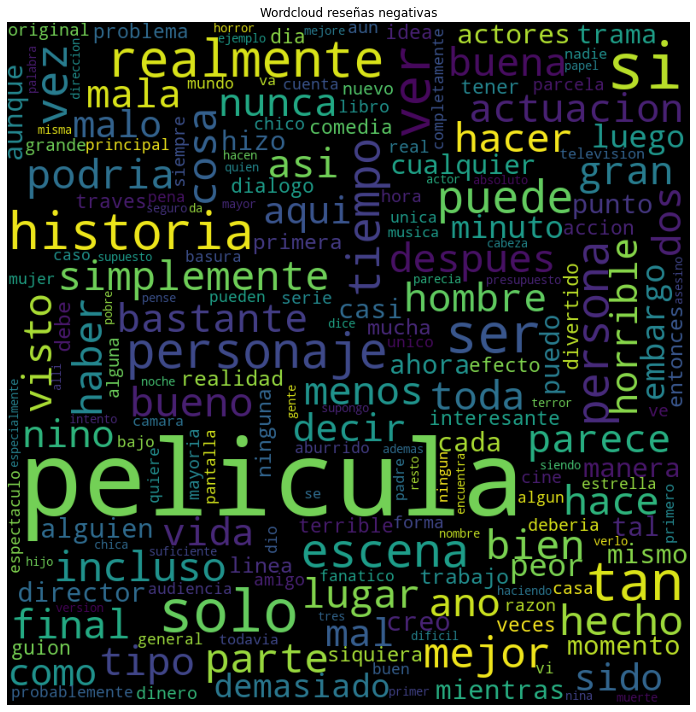

In [ ]:
# Muestra la nube de palabras


Vemos que aparecen palabras como 'malo', 'terrible', 'horrible', 'peor', etc.

## Longitud de los textos

**Siempre es conveniente comprobar la longitud de los textos por si esto nos pudiera dar alguna pista. Crea un histograma que compare la distribución de la longitud de los textos de las reseñas para ambas etiquetas de salida. ¿Qué observas?**

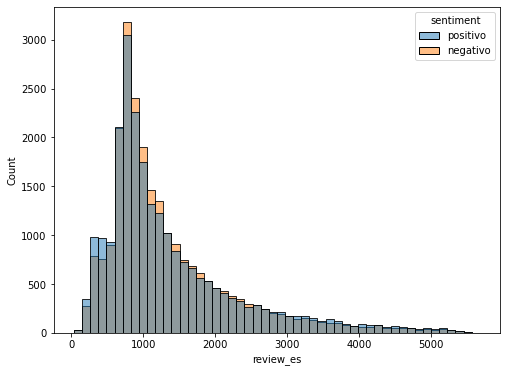

## Entrenamiento del modelo

Vamos a usar la clase [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) de Scikit-Learn para crear un flujo que nos permita:
1. Vectorizar los textos usando [`TfidfVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
2. Entrenar un clasificador de tipo [`MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html?highlight=multinomialnb#sklearn.naive_bayes.MultinomialNB).

**Separa la variable de entrada, en este caso la columna `review_es_clean` que contiene los textos preprocesados, de la variable de salida y asígnalas a dos variables llamadas `X` e `y` respectivamente.**

**Divide el dataset en los conjuntos de entrenamiento y prueba en una proporción de 80/20.**

**Usando la clase `Pipeline` instancia un flujo que primero vectorice los textos de las reseñas usando `TfidfVectorizer` y, a continuación, entrene un clasificador de tipo Naive Bayes multinomial usando la matriz de características TF-IDF generada al vectorizar.**

**Ahora vamos realizar una búsqueda de hiperparámetros usando `GridSearchCV`. A continuación, te dejamos como sugerencia algunos valores para los hiperparámetros que puedes ajustar, aunque puedes usar los que quieras. Comenta y descomenta lo que consideres, pero ten en cuenta que el tiempo de búsqueda crecerá de forma exponencial al número de valores que quieras probar, ¡elige sabiamente!**

In [ ]:
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__min_df': (1, 3, 5),
    'tfidf__max_features': (None, 5000, 10000, 50000),
    'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)),
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2', None),
    'clf__alpha': (1, 0.1, 0.001)
}

**Instancia la clase `GridSearchCV` a la que le pasaremos nuestro pipeline y el diccionario con los hiperparámetros. Te aconsejamos un `cv=3` para reducir el tiempo de entrenamiento**

**Usa la función `fit()` para realizar la búsqueda de hiperparámetros en la instancia de `GridSearchCV` que acabas de crear. ¡Ojo! Es paso puede tardar bastante en función de los valores de hiperparámetros que hayas elegido.**

Performing grid search...
Pipeline: ['tfidf', 'clf']
Selected parameters:
{'tfidf__min_df': (1, 3, 5), 'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3), (1, 4)), 'clf__alpha': (1, 0.1, 0.001)}

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV 1/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.862 total time=   2.8s
[CV 2/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.853 total time=   2.7s
[CV 3/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 1);, score=0.856 total time=   2.7s
[CV 1/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.884 total time=  12.0s
[CV 2/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.876 total time=  12.2s
[CV 3/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 2);, score=0.878 total time=  12.1s
[CV 1/3] END clf__alpha=1, tfidf__min_df=1, tfidf__ngram_range=(1, 3);, score=0.884 total time=  24.5s
[CV 2/3] END clf__alpha=1,

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': (1, 0.1, 0.001),
                         'tfidf__min_df': (1, 3, 5),
                         'tfidf__ngram_range': ((1, 1), (1, 2), (1, 3),
                                                (1, 4))},
             verbose=3)

**Una vez terminada la búsqueda imprime la mejor puntuación obtenida, así como el mejor conjunto de hiperparámetros encontrado.**

Best score: 0.885
Best parameters set:
	clf__alpha: 0.1
	tfidf__min_df: 1
	tfidf__ngram_range: (1, 4)


**Ahora que tenemos los hiperparámetros que mejor funcionan, instancia de nuevo el pipeline con ellos y entrena el clasificador usando los hiperparámetros seleccionados.**

In [ ]:
# Instancia el flujo


In [ ]:
# Realiza el entrenamiento


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4))),
                ('clf', MultinomialNB(alpha=0.1))])

## Evaluación del modelo

**Realiza las predicciones para el conjunto de prueba.**

**Imprime el accuracy score para el conjunto de prueba del modelo que acabas de entrenar.**

0.8986093814860938

**Muestra la matriz de confunsión para el clasificador.**

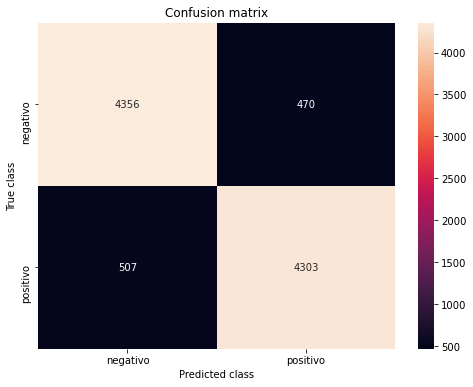

**Imprime el informe de clasificación.**

              precision    recall  f1-score   support

    negativo       0.90      0.90      0.90      4826
    positivo       0.90      0.89      0.90      4810

    accuracy                           0.90      9636
   macro avg       0.90      0.90      0.90      9636
weighted avg       0.90      0.90      0.90      9636



**Por último, crea una visualización con la curva ROC y la métrica del área bajo la curva.**

In [ ]:
# Calcula las métricas


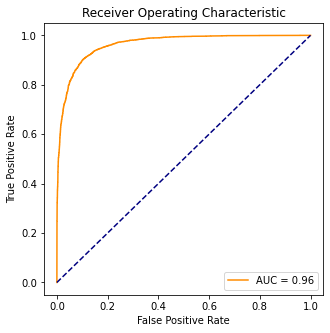

In [ ]:
# Muestra el gráfico


## Realizar predicciones

Ahora lo que vamos a hacer es pasar al modelo entrenado nuestras propias reseñas y ver cómo se comporta el clasificador. Recuerda que estás reseñas tienen que llevar el mismo preprocesamiento que hemos usado para crear los conjuntos de entrenamiento y prueba (todo en minúsculas, sin acentos ni símbolos de puntuación, etc.).

**Inventa una reseña positiva y otra negativa y pásaselas al modelo para ver qué etiqueta les pone.**

In [ ]:
# Reseña positiva


array(['positivo'], dtype='<U8')

In [ ]:
# Reseña negativa


array(['negativo'], dtype='<U8')

In [ ]:
# Podemos pasar las dos en una lista


array(['positivo', 'positivo'], dtype='<U8')

**(Opcional) Crea una función a la que le pasemos una lista con las reseñas sin preprocesar y nos las devuelva preprocesadas para pasárselas al modelo.**

In [ ]:
# Define la función de preprocesamiento de los textos


In [ ]:
# Crea una lista con las reseñas en bruto


In [ ]:
# Preprocesa las reseñas y guárdalas en una variable


['gru entretenida', 'titanic pelicula aburrida visto vida']

In [ ]:
# Haz la predicción para las reseñas preprocesadas


array(['positivo', 'negativo'], dtype='<U8')

**(Opcional) Prueba a crear y entrenar el pipeline con algún otro algoritmo de clasificación de tu elección (`LogisticRegression`, `LinearSVC`, `RandomForestClassifier`...) a ver si es capaz de mejorar las métricas obtenidas hasta ahora.**